In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.25)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

## MSM of a bistable model potential
Here we analyze a Brownian dynamics trajectory on the model potential by Berezhkovskii et al ([*J. Chem. Phys.*, 2014](https://doi.org/10.1063/1.4902243)), used in the context of single molecule force spectroscopy by Cossio, Hummer and Szabo ([*PNAS*, 2015](https://doi.org/10.1073/pnas.1519633112)).

### Analysis

First of all, we import the [PyEMMA](www.emma-project.org) software package.

In [2]:
import pyemma
pyemma.__version__

'2.5.7'

Next we load a trajectory run on the bistable potential and check for the shape of the trajectory.

In [3]:
h5file = "./data/cossio_kl1.3_Dx1_Dq1.h5"
f = h5py.File(h5file, 'r')
data0 = np.array(f['data'])
f.close()
X = data0[:,[1,2]]

In [4]:
X0, X1 = X[:,0], X[:,1]
X.shape, X0.shape, X1.shape

((25001, 2), (25001,), (25001,))

In [5]:
from pyemma.util.contexts import settings
import pyemma.coordinates as coor
import pyemma.plots as mplt

Check $x$ and $y$ coordinates along the trajectory. We see that as we would expect for this model both coordinates are highly correlated.

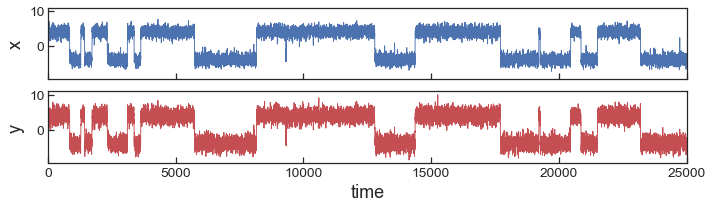

In [6]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10, 3.))
ax[0].plot(range(len(X[:,0])), X[:,0], linewidth=0.9, c='b')
ax[1].plot(range(len(X[:,1])), X[:,1], linewidth=0.9, c='r')
ax[1].set_xlabel('time', fontsize=18)
ax[0].set_ylabel('x', fontsize=18)
ax[1].set_ylabel('y', fontsize=18)
ax[0].set_xlim(0, 25000)
plt.tight_layout()
#plt.savefig('../figures/cossio/traj_1d.png', dpi=300, transparent=True)

Then we load the trajectory into PyEMMA.

In [7]:
inp = coor.source([data0[:,[1,2]]])

In [8]:
print ('number of trajectories = ', inp.ntraj)
print('1st trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())

number of trajectories =  1
1st trajectory length =  25001
number of dimension =  2


### Traditional MSM construction
In this case, for producing the standard MSM we will run k-means clustering of the dataset. Alternatively, datapoints could be assigned to states using a grid.

In [9]:
cl = coor.cluster_kmeans(data=[X], k=100, max_iter=150) #, stride=1
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
ccx = cl.clustercenters[:,0]
ccy = cl.clustercenters[:,1]

For visualization purposes, we generate the free energy surface described by Berezhkovskii et al. and plot together with the cluster centers resulting from K-means clustering. For this we will need a separate bit of Cython code available at [Github](https://github.com/daviddesancho/smFSmodels).

In [10]:
import cossio
import sys
yp = np.linspace(-10.,10.,400)
xp = np.linspace(-10.,10.,400)
mat = np.zeros((len(xp), len(yp)))
for i, x_i in enumerate(xp):
    for j, y_i in enumerate(yp):
        aux = cossio.Gqx(x_i,y_i, kl=1.3)
        mat[i, j] = aux

Xpp, Ypp = np.meshgrid(xp,yp)

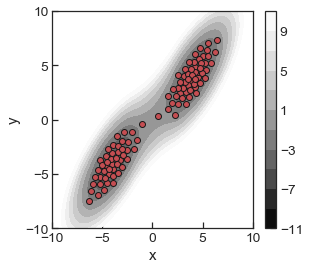

In [12]:
fig, ax = plt.subplots(figsize=(4.5,4))
lev = np.arange(-11,13, 2)
CS = ax.contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r')
ax.plot(ccx, ccy, linewidth=0, marker='o', mfc='r', mec='k')
#im = ax.imshow(mat, extent=[-10, 10, -10, 10], origin='lower',
#           cmap='viridis', alpha=0.5);
plt.colorbar(CS)
ax.set_xlabel('x')
ax.set_ylabel('y')
yt = np.arange(-10,10,5)
ax.set_yticks([-10,-5,0,5,10])

Construct the MSM corresponding to the aforementioned discretization.

In [13]:
import pyemma.msm as msm
import pyemma.plots as mplt
lags = [1, 2, 5, 10, 20, 30]

its = msm.its(dtrajs, lags=lags, errors='bayes')

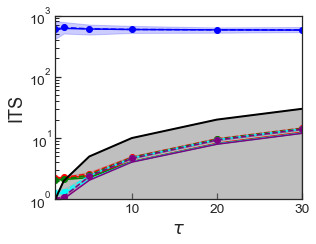

In [14]:
fig, ax = plt.subplots(figsize=(4.5,3.5))
mplt.plot_implied_timescales(its, ylog=True, nits=5)
ax.set_ylim(1,1000)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('ITS', fontsize=18)
plt.tight_layout()
#plt.savefig('../figures/cossio/cossio-kmeans-times.png', dpi=300, transparent=True)

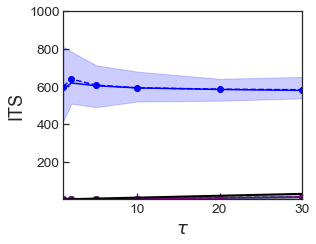

In [15]:
fig, ax = plt.subplots(figsize=(4.5,3.5))
mplt.plot_implied_timescales(its, ylog=False, nits=5)
ax.set_ylim(1,1000)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('ITS', fontsize=18)
plt.tight_layout()
#plt.savefig('../figures/cossio/cossio-kmeans-times_linear.png', dpi=300, transparent=True)

In [16]:
M = msm.estimate_markov_model(dtrajs, 10)

In [17]:
M.timescales()[:2]

array([591.83478345,   4.12327023])

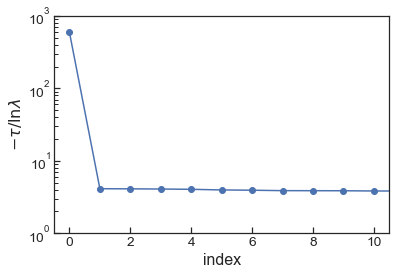

In [18]:
fig, ax = plt.subplots()
ax.plot(M.timescales(),linewidth=1.5, marker='o')
ax.set_xlabel(r'index', fontsize=16)
ax.set_ylabel(r'$-\tau/\ln \lambda$', fontsize=16)
ax.set_xlim(-0.5,10.5)
ax.set_ylim(1,1000)
plt.yscale('log')

In [19]:
eigvec = M.eigenvectors_left()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

first eigenvector is one: False (min=-0.013663609560914667, max=0.013265163994366941)


(array([ 5., 10.,  5.,  9.,  6.,  7.,  7.,  4.,  1.,  4.,  7.,  6.,  4.,
         5.,  5.,  6.,  5.,  3.,  1.]),
 array([-0.01741062, -0.01530601, -0.01320141, -0.0110968 , -0.00899219,
        -0.00688759, -0.00478298, -0.00267838, -0.00057377,  0.00153084,
         0.00363544,  0.00574005,  0.00784465,  0.00994926,  0.01205387,
         0.01415847,  0.01626308,  0.01836768,  0.02047229,  0.0225769 ]),
 <a list of 19 Patch objects>)

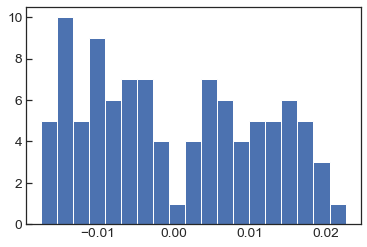

In [20]:
plt.hist(eigvec[1], bins=np.linspace(np.min(eigvec[1]), np.max(eigvec[1]), 20))

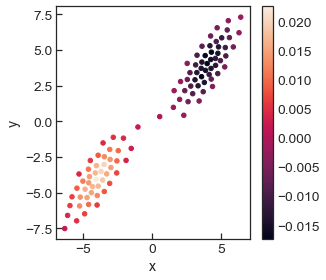

In [40]:
fig, ax = plt.subplots(figsize=(4.5, 4))
sc = ax.scatter(cl.clustercenters[:,0], cl.clustercenters[:,1], c=eigvec[1], s=20)
plt.colorbar(sc)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
plt.tight_layout()

Since there is a single slow process, let us lump the microstates into two macrostates by using PCCA+ spectral clustering.

In [22]:
M.pcca(2)

PCCA(P=array([[0.     , 0.     , ..., 0.     , 0.     ],
       [0.     , 0.05328, ..., 0.03694, 0.0041 ],
       ...,
       [0.     , 0.02416, ..., 0.02957, 0.00268],
       [0.     , 0.02273, ..., 0.02276, 0.     ]]),
   m=2)

In [23]:
pcca_sets = M.metastable_sets

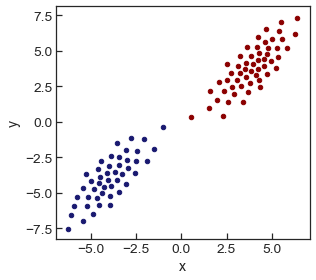

In [24]:
fig, ax = plt.subplots(figsize=(4.5, 4))
#CS = ax.contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r', alpha=0.5)
#ax.imshow(mat, extent=[-10, 10, -10, 10], origin='lower',
#           cmap='viridis', alpha=0.5);#RdGy
ax.scatter(cl.clustercenters[pcca_sets[0],0], cl.clustercenters[pcca_sets[0],1], color='midnightblue', s=20)
ax.scatter(cl.clustercenters[pcca_sets[1],0], cl.clustercenters[pcca_sets[1],1], color='darkred', s=20)
#im = ax.imshow(mat, extent=[-10, 10, -10, 10], origin='lower',
#           cmap='viridis', alpha=0.5);
#plt.colorbar(CS)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
plt.tight_layout()
#plt.savefig('../figures/cossio/cossio-kmeans.png', dpi=300, transparent=True)

In [64]:
A = [i for i, x in enumerate(eigvec[1]) if (x>0.015)] 
B = [i for i, x in enumerate(eigvec[1]) if (x<-0.015)] 
flux = pyemma.msm.tpt(M, A, B)

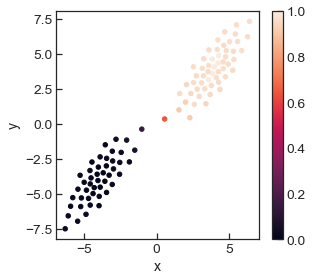

In [65]:
fig, ax = plt.subplots(figsize=(4.5, 4))
sc = ax.scatter(cl.clustercenters[:,0], cl.clustercenters[:,1], c=flux.committor, s=20)
plt.colorbar(sc)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
plt.tight_layout()

Text(0, 0.5, '$p_{fold}$')

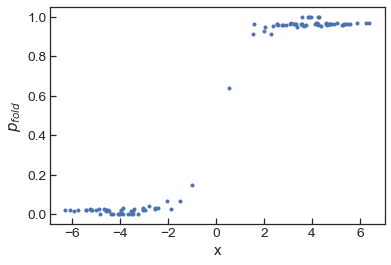

In [66]:
fig, ax = plt.subplots()
ax.plot(cl.clustercenters[:,0], flux.committor, '.')
ax.set_xlabel('x')
ax.set_ylabel(r'$p_{fold}$')

Chapman-Kolmogorov test for the MSM resulting from PCCA+ clustering.

In [27]:
M = msm.bayesian_markov_model(dtrajs, 10)

In [28]:
ck = M.cktest(2) #M.cktest(3)

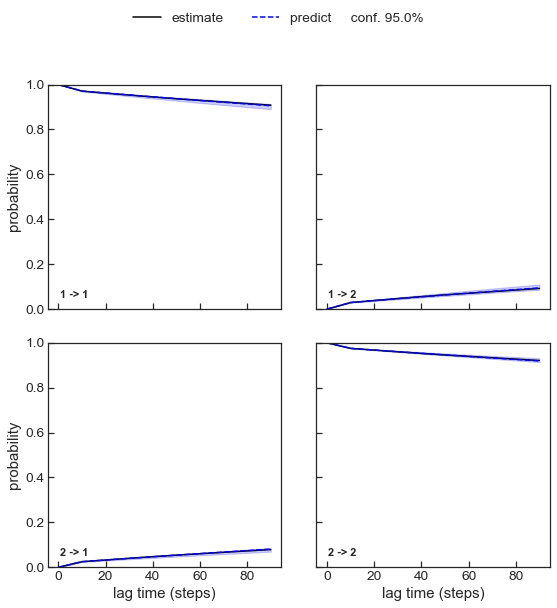

In [29]:
plt.rcParams.update({'font.size': 11})
fig, axes = mplt.plot_cktest(ck, figsize=(9, 9), padding_between=0.15, padding_top=0.13)
#plt.savefig("../figures/cossio/cossio-pcca-ck.png")
#mplt.plot_cktest(ck)

### MSM construction exploting density-based clustering

In [68]:
import hdbscan

In [69]:
data = np.vstack((X))

In [70]:
np.shape(data)

(25001, 2)

Apply HDBSCAN clustering with 'minimum cluster size' equal to 50 and 'minimum samples' equal to 70 to previously normalized data. Then look into resulting clusters.

In [71]:
from sklearn.preprocessing import StandardScaler
norm_X = StandardScaler().fit_transform(data)

In [72]:
hdb = hdbscan.HDBSCAN(min_cluster_size=100).fit(norm_X)

In [73]:
np.unique(hdb.labels_)

array([-1,  0,  1])

-1 cluster label denotes 'noise', so two clusters are obtained from HDBSCAN clustering. The latter can be better understood from the corresponding condensed tree plot. For more details see https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

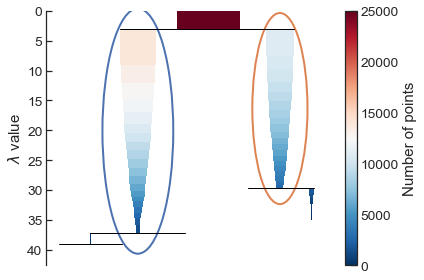

In [74]:
fig = plt.figure()
ax = hdb.condensed_tree_.plot(select_clusters=True, cmap='RdBu_r', selection_palette=sns.color_palette())
plt.tight_layout()
#plt.savefig("../figures/cossio/cossio-hdbscan-tree.png", dpi=300)

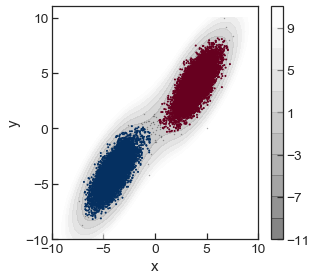

In [75]:
fig, ax = plt.subplots(figsize=(4.5, 4))
assign = hdb.labels_ >= 0
CS = ax.contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r', alpha=0.5)
ax.scatter(data[assign,0],data[assign,1], marker='o', 
                cmap='RdBu', s=1, c=hdb.labels_[assign])
nassign = hdb.labels_ == -1
ax.scatter(data[nassign,0],data[nassign,1], marker='.', 
                s=0.5, c='k', alpha=0.5)
plt.colorbar(CS)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.tight_layout()

In order to be more stringent with the TBA methodology, let us set as 'noise' those points whose probability to be in their corresponding clusters is less than 40%.

In [76]:
for i, x_i in enumerate(hdb.labels_):
    if hdb.probabilities_[i] < 0.4:
        hdb.labels_[i] = -1
assign = hdb.labels_>= 0
nassign = hdb.labels_ < 0

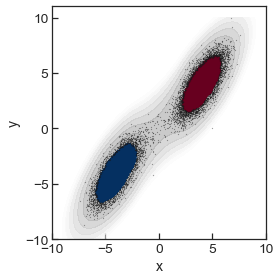

In [77]:
fig, ax = plt.subplots(figsize=(4.,4))
# histogram data
CS = ax.contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r', alpha=0.5)
#plt.colorbar(CS)

assign = hdb.labels_ >= 0
ax.scatter(data[assign,0],data[assign,1], marker='o', 
                cmap='RdBu', s=1, c=hdb.labels_[assign])
nassign = hdb.labels_ == -1
ax.scatter(data[nassign,0],data[nassign,1], marker='.', 
                cmap='k', s=0.1, c='k')
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
plt.tight_layout()
#plt.savefig('../figures/cossio/cossio-hdbscan.png', dpi=300, transparent=True)

If we consider clusterization good enough, proceed to lag time selection and MSM estimation

In [78]:
import pyemma.msm as msm
import pyemma.plots as mplt
lags = [1, 2, 5, 10, 20, 30]

In [79]:
labels_tba = []
for i, l in enumerate(hdb.labels_):
    if l == -1:
        try:
            labels_tba.append(labels_tba[-1])
        except IndexError:
            pass
    else:
        labels_tba.append(l)

In [80]:
#its_hdb = msm.its(hdb.labels_[assign], lags=lags, errors='bayes')
its_hdb = msm.its(labels_tba, lags=lags, errors='bayes')

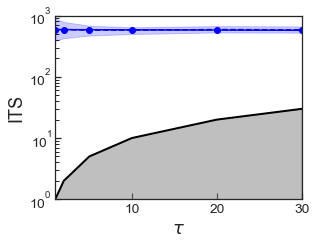

In [81]:
fig, ax = plt.subplots(figsize=(4.5,3.5))
mplt.plot_implied_timescales(its_hdb, ylog=True)
ax.set_ylim(1,1000)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('ITS', fontsize=18)
plt.tight_layout()
#plt.savefig('../figures/cossio/cossio-hdbscan-its.png', dpi=300, transparent=True)

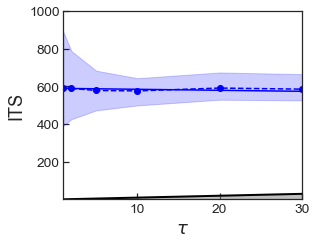

In [82]:
fig, ax = plt.subplots(figsize=(4.5,3.5))
mplt.plot_implied_timescales(its_hdb, ylog=False)
ax.set_ylim(1,1000)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('ITS', fontsize=18)
plt.tight_layout()
#plt.savefig('../figures/cossio/cossio-hdbscan-its-linear.png', dpi=300, transparent=True)

In [83]:
M_hdb = msm.estimate_markov_model(labels_tba, 10)

In [84]:
M_hdb.timescales()

array([584.33007253])

Validate the obtained HDBSCAN MSM by carrying out the corresponding Chapman-Kolmogorov test.

In [85]:
M = msm.bayesian_markov_model(labels_tba, 10)

In [86]:
ck = M.cktest(2)

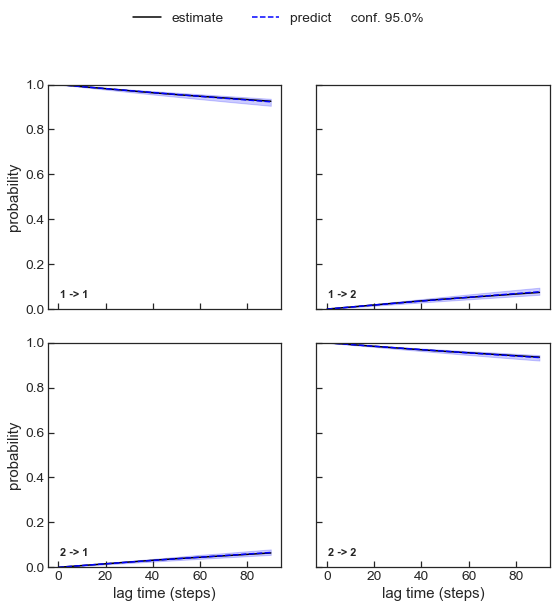

In [87]:
plt.rcParams.update({'font.size': 11})
fig, axes = mplt.plot_cktest(ck, figsize=(9, 9), padding_between=0.15, padding_top=0.13)

#plt.savefig("../figures/cossio/cossio-hdbscan-ck.png", dpi=300)

## Exploring parameter space

### Min cluster size

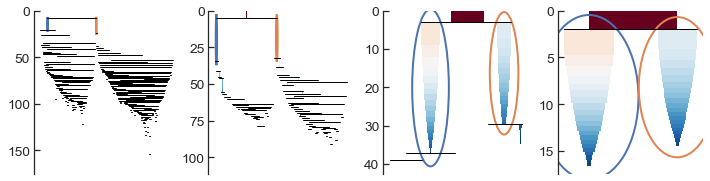

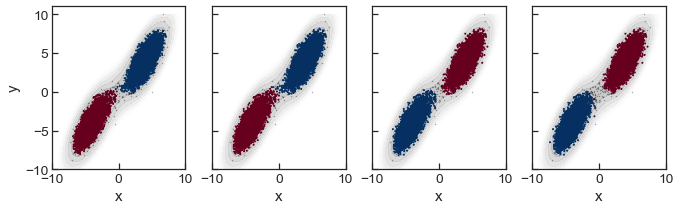

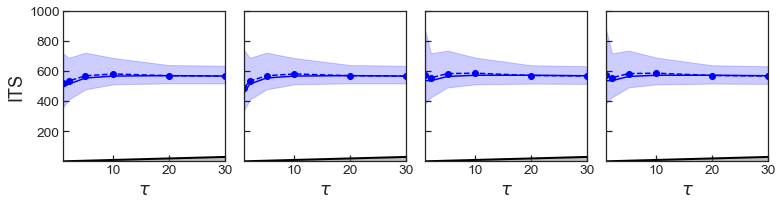

In [147]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))
fig2, ax2 = plt.subplots(1,4, figsize=(11,3), sharex=True, sharey=True)
fig3, ax3 = plt.subplots(1,4, figsize=(11,3), sharex=True, sharey=True)

for i, mcs in enumerate([10, 20, 100, 500]):
    hdb = hdbscan.HDBSCAN(min_cluster_size=mcs).fit(norm_X)
    hdb.condensed_tree_.plot(select_clusters=True, cmap='RdBu_r', colorbar=False, \
                             axis=ax[i], selection_palette=sns.color_palette())
    ax[i].set_ylabel('')

    assign = hdb.labels_ >= 0
    CS = ax2[i].contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r', alpha=0.5)
    ax2[i].scatter(data[assign,0],data[assign,1], marker='o', 
                cmap='RdBu', s=1, c=hdb.labels_[assign])
    nassign = hdb.labels_ == -1
    ax2[i].scatter(data[nassign,0],data[nassign,1], marker='.', 
                s=0.5, c='k', alpha=0.5)
#plt.colorbar(CS)
    ax2[i].set_xlabel('x')
    
    labels_tba = []
    for k, l in enumerate(hdb.labels_):
        if l == -1:
            try:
                labels_tba.append(labels_tba[-1])
            except IndexError:
                pass
        else:
            labels_tba.append(l)

    its_hdb = msm.its(labels_tba, lags=lags, errors='bayes')
    
    mplt.plot_implied_timescales(its_hdb, ax=ax3[i], ylog=False)
    ax3[i].set_xlabel(r'$\tau$', fontsize=18)
    ax3[i].set_ylabel('')

ax2[0].set_ylabel('y')
plt.tight_layout()


ax3[0].set_ylabel('ITS', fontsize=18)
ax3[0].set_ylim(1,1000)
plt.tight_layout()


#plt.savefig("../figures/cossio/cossio-hdbscan-tree.png", dpi=300)

### Soft clustering

In [126]:
hdb = hdbscan.HDBSCAN(min_cluster_size=100).fit(norm_X)
import copy

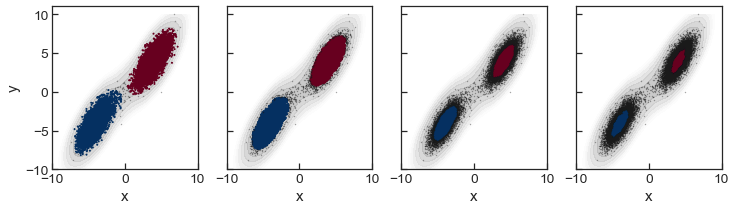

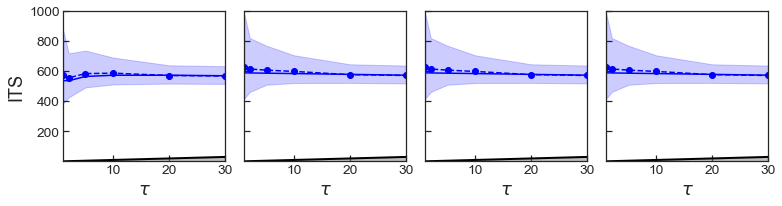

In [129]:
fig, ax = plt.subplots(1,4, figsize=(12, 3.), sharex=True, sharey=True)
fig2, ax2 = plt.subplots(1,4, figsize=(11,3), sharex=True, sharey=True)

for j, pc in enumerate([0.0, 0.2, 0.5, 0.7]):
    hdb_copy = copy.deepcopy(hdb)
    for i, x_i in enumerate(hdb_copy.labels_):
        if hdb_copy.probabilities_[i] < pc:
            hdb_copy.labels_[i] = -1

    assign = hdb_copy.labels_ >= 0
    CS = ax[j].contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r', alpha=0.5)
    ax[j].scatter(data[assign,0],data[assign,1], marker='o', 
                cmap='RdBu', s=1, c=hdb_copy.labels_[assign])
    nassign = hdb_copy.labels_ == -1
    ax[j].scatter(data[nassign,0],data[nassign,1], marker='.', 
                s=0.5, c='k', alpha=0.5)
#plt.colorbar(CS)
    ax[j].set_xlabel('x')
    
    
    labels_tba = []
    for i, l in enumerate(hdb_copy.labels_):
        if l == -1:
            try:
                labels_tba.append(labels_tba[-1])
            except IndexError:
                pass
        else:
            labels_tba.append(l)

    its_hdb = msm.its(labels_tba, lags=lags, errors='bayes')
    
    mplt.plot_implied_timescales(its_hdb, ax=ax2[j], ylog=False)
    ax2[j].set_xlabel(r'$\tau$', fontsize=18)
    ax2[j].set_ylabel('')
ax2[0].set_ylabel('ITS', fontsize=18)
ax2[0].set_ylim(1,1000)
plt.tight_layout()

    
ax[0].set_ylabel('y')
plt.tight_layout()



/home/daviddesancho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/daviddesancho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


Text(0, 0.5, '$p_{fold}$')

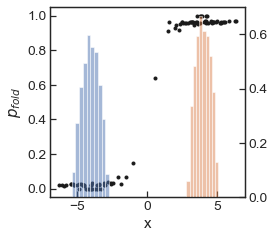

In [133]:
fig, ax = plt.subplots(figsize=(3.5,3.5))
axt = ax.twinx()
axt.hist(data[hdb_copy.labels_==1, 0], normed=True, alpha=0.5)
axt.hist(data[hdb_copy.labels_==0, 0], normed=True, alpha=0.5)
ax.plot(cl.clustercenters[:,0], flux.committor, '.', color='k')
ax.set_xlabel('x')
ax.set_ylabel(r'$p_{fold}$')